# Abbreviation Application
## A Stylochronometric Study of the Abbreviations in the Oeuvre of Herne’s Speculum Scribe 

This is the code applied in our (accepted) contribution to the conference Digital Humanities Benelux 2024, held from June 5-7 in Leuven. This contribution is part of the research project “Silent voices: A Digital Study of the Herne Charterhouse as a Textual Community (ca. 1350-1400)”, funded by the Flemish Research Agency (Belgium) at the University of Antwerp. The project studies the evolution of the scribal culture in the Herne monastery through computational text analysis.

Caroline Vandyck (caroline.vandyck@uantwerpen.be) and Mike Kestemont

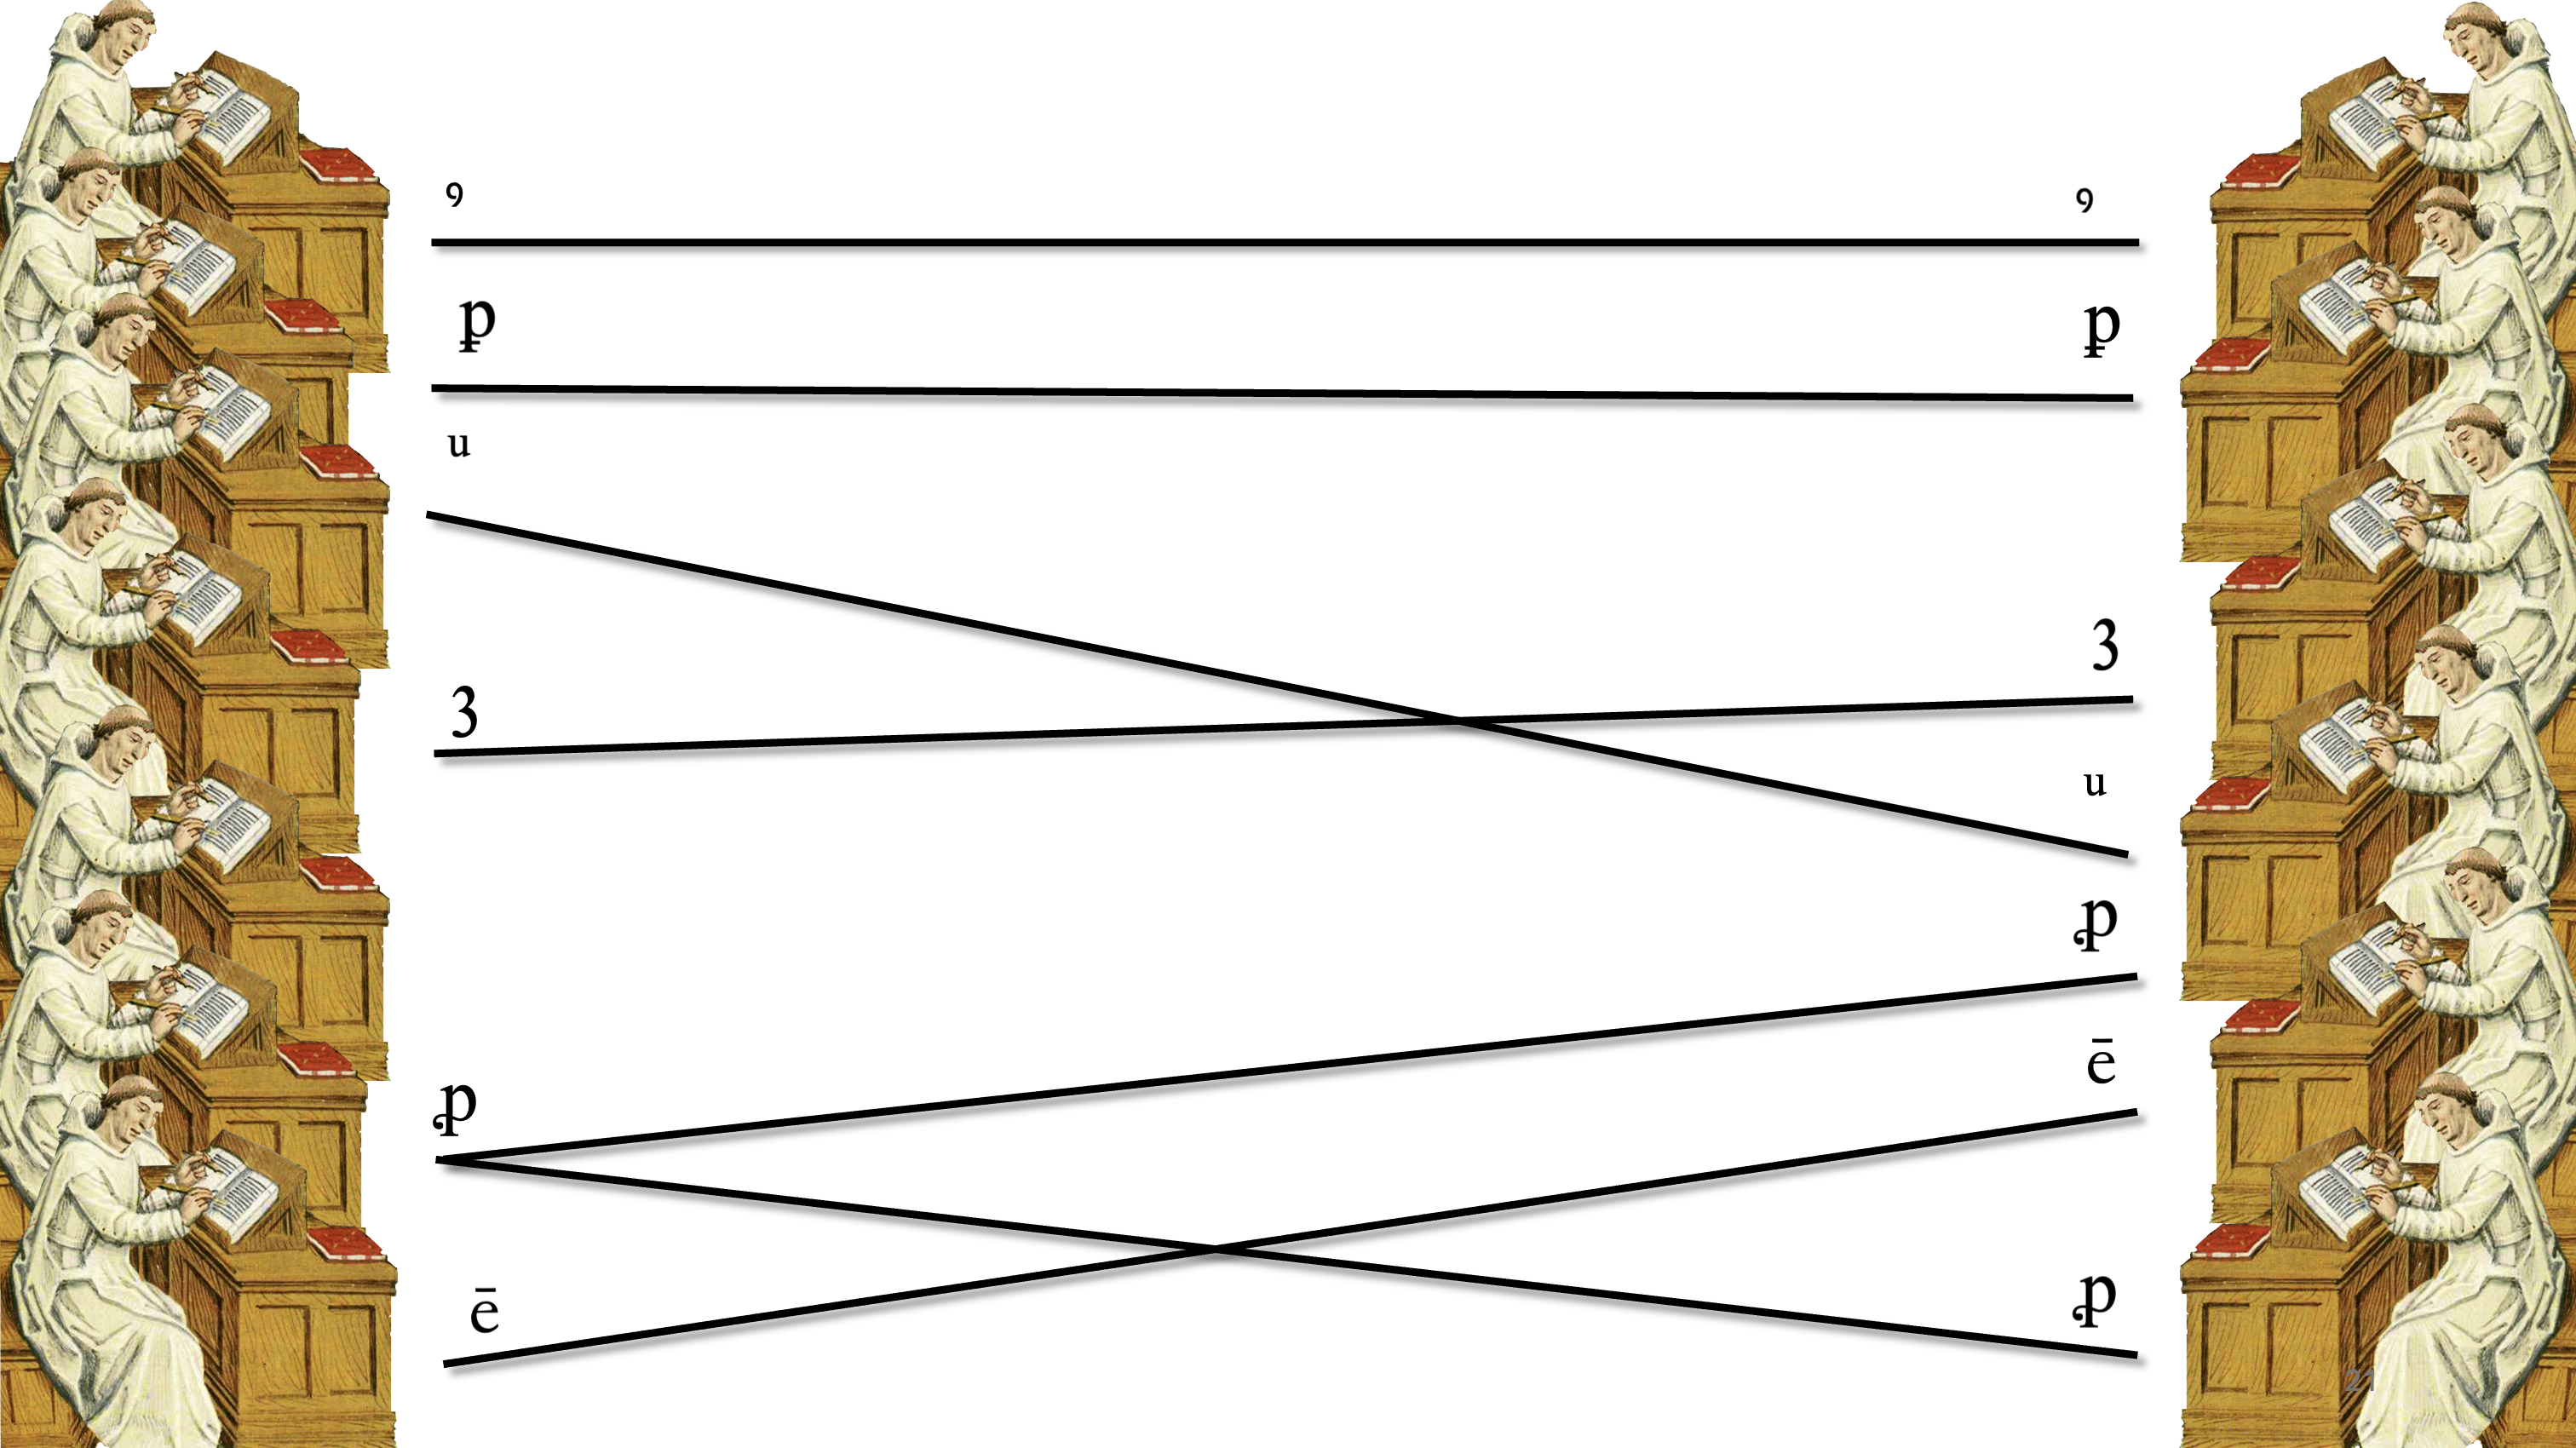

### Loading libraries

In [1]:
import pandas as pd
from collections import Counter
import regex as re
import grapheme
from sklearn.decomposition import PCA
from functools import partial
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import unicodedata

### Loading data and metadata

In [2]:
# Loading in the data
transcriptions = pd.read_excel('data/manuscript_data_metadata.xlsx')

# The id-column is a concatenation of the signature of the codex, the production unit, and the scribe of the unit
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']

# Correcting a date in the dataframe
transcriptions.loc[transcriptions['id'] == 'Vienna ÖNB 13.708-II-α', 'date'] = 1393

# Show
transcriptions.head(5)

Unnamed: 0               codex_sig  transkribuspage  \
0           0  Brussels KBR 1805-1808                7   
1           1  Brussels KBR 1805-1808                7   
2           2  Brussels KBR 1805-1808                8   
3           3  Brussels KBR 1805-1808                8   
4           4  Brussels KBR 1805-1808                9   

             image_filename        page_xml_filename  image_width  \
0  0007_KBR_1805-08_1r.tiff  0007_KBR_1805-08_1r.xml         5186   
1  0007_KBR_1805-08_1r.tiff  0007_KBR_1805-08_1r.xml         5186   
2  0008_KBR_1805-08_1v.tiff  0008_KBR_1805-08_1v.xml         5186   
3  0008_KBR_1805-08_1v.tiff  0008_KBR_1805-08_1v.xml         5186   
4  0009_KBR_1805-08_2r.tiff  0009_KBR_1805-08_2r.xml         5186   

   image_height region_type  \
0          7123      header   
1          7123   paragraph   
2          7123   paragraph   
3          7123  marginalia   
4          7123   paragraph   

                                         coordinates  fraction  ...  \
0                1405,478 3598,478 3598,721 1405,721      0.01  ...   
1              1359,751 3792,751 3792,2645 1359,2645      0.12  ...   
2              1736,658 3985,658 3985,1643 1736,1643      0.06  ...   
3            2414,1705 4016,1705 4016,1851 2414,1851      0.01  ...   
4  859,5840 847,5678 835,5462 781,4838 751,4480 7...      0.23  ...   

           content     language scribe  production unit local Herne product  \
0          proloog  middledutch      a                I                 yes   
1          proloog  middledutch      a                I                 yes   
2          proloog  middledutch      a                I                 yes   
3          proloog  middledutch      a                I                 yes   
4  dialogenGreg1_3  middledutch      α                I                 yes   

   date       translator transcription HTR-model used  \
0  1400  bibletranslator            GT            NaN   
1  1400  bibletranslator            GT            NaN   
2  1400  bibletranslator            GT            NaN   
3  1400  bibletranslator            GT            NaN   
4  1395  bibletranslator            GT            NaN   

                           id  
0  Brussels KBR 1805-1808-I-a  
1  Brussels KBR 1805-1808-I-a  
2  Brussels KBR 1805-1808-I-a  
3  Brussels KBR 1805-1808-I-a  
4  Brussels KBR 1805-1808-I-α  

[5 rows x 27 columns]

In [3]:
# We merge together all text from the same production units.

units = []
plain_char = re.compile("[A-Za-z]+")

for prod_unit_id, prod_unit in transcriptions.groupby('id'):
    prod_unit = prod_unit.sort_values('transkribuspage')
    prod_unit = prod_unit[~prod_unit['text'].isna()]
    if not len(prod_unit):
        continue
    # Merge all text fragments and keep new lines
    text = '\n'.join(t for t in prod_unit['text'])

    # Deleting double spaces and adding new lines between all fragments
    text = '\n'.join(' '.join(line.strip().split()) for line in text.split('\n'))

    
    date = prod_unit.sample(1)['date'].values[0]
    scribe = prod_unit.sample(1)['scribe'].values[0]
    sig = prod_unit.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(prod_unit['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = prod_unit.sample(1)['translator'].values[0]
    units.append((prod_unit_id, date, text, scribe, sig, prod_unit_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H

pu       date  \
0         Brussels KBR 1805-1808-I-a       1400   
1         Brussels KBR 1805-1808-I-α       1395   
2        Brussels KBR 1805-1808-II-D       1395   
3        Brussels KBR 1805-1808-II-α       1395   
4    Brussels KBR 1805-1808-III-none       1395   
..                               ...        ...   
118                Vienna ÖNB 65-I-a  1375-1400   
119                Vienna ÖNB 65-I-γ  1375-1400   
120               Vienna ÖNB 65-II-α  1375-1400   
121              Vienna ÖNB 65-III-γ  1375-1400   
122               Vienna ÖNB 65-IV-γ  1375-1400   

                                                  text  \
0    Een voorredene op sinte gregoriꝰ dyalogus\nDE ...   
1    Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...   
2    Hiʼ begēt de pierde boec vā gᵉgerna\n¶ Dyalogu...   
3    De dʼde boec gaꝫ hiʼ vte Hiʼ volgen\ndē capite...   
4    DJt boec hoert den bruedʼs vādē goede cloestin...   
..                                                 ...   
118  liber iste ꝑtinet ad cenob sā pauli zonia\nDo...   
119  ‡ d\nblie die pase on heeren ihoes\nso voerga ...   
120  huiꝰ lcōt corrigat librū qui valde īcorrectꝰ ē...   
121  vᵃ\nDe wijsheit . Dat en mach niet sijn .\nNoc...   
122  ōōsolau ꝯso\nHoe orborlec dat es den knechte g...   

                          scribe               signature  \
0       Brussels KBR 1805-1808-a  Brussels KBR 1805-1808   
1                              α  Brussels KBR 1805-1808   
2       Brussels KBR 1805-1808-D  Brussels KBR 1805-1808   
3                              α  Brussels KBR 1805-1808   
4    Brussels KBR 1805-1808-none  Brussels KBR 1805-1808   
..                           ...                     ...   
118              Vienna ÖNB 65-a           Vienna ÖNB 65   
119                            γ           Vienna ÖNB 65   
120                            α           Vienna ÖNB 65   
121                            γ           Vienna ÖNB 65   
122                            γ           Vienna ÖNB 65   

                                  id       translator          content  
0         Brussels KBR 1805-1808-I-a  bibletranslator          proloog  
1         Brussels KBR 1805-1808-I-α  bibletranslator  dialogenGreg1_3  
2        Brussels KBR 1805-1808-II-D  bibletranslator    dialogenGreg4  
3        Brussels KBR 1805-1808-II-α             none    inhoudsopgave  
4    Brussels KBR 1805-1808-III-none             none             none  
..                               ...              ...              ...  
118                Vienna ÖNB 65-I-a              NaN             note  
119                Vienna ÖNB 65-I-γ              NaN              TOC  
120               Vienna ÖNB 65-II-α              NaN        horlogium  
121              Vienna ÖNB 65-III-γ              NaN        horlogium  
122               Vienna ÖNB 65-IV-γ              NaN        horlogium  

[123 rows x 8 columns]

In [4]:
# If a date is approximated (f.e. 1325-1350), we have to convert it 
# to one single year in order to work with it. Accordingly, we calculate
# the mean and store it in the 'num_date'-column

num_dates = []

for d in H['date']:
    if d in ('unknown', 'no', 'none'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H

pu       date  \
82                     Saint Petersburg BAN O 256-II-G  1325-1350   
80                      Saint Petersburg BAN O 256-I-B  1325-1350   
81                 Saint Petersburg BAN O 256-I-II-B-G  1325-1350   
26                          Brussels KBR 2879-80-III-C  1325-1350   
25                        Brussels KBR 2879-80-III-B-C  1325-1350   
..                                                 ...        ...   
76      Paris Bibliothèque de l'Arsenal 8224-none-none       none   
77   Paris Bibliothèque de l'Arsenal 8224-none-unknown       none   
89                Saint Petersburg BAN O 256-none-none       none   
95                         Vienna ÖNB 12.857-none-none         no   
117                        Vienna ÖNB 13.708-none-none       none   

                                                  text  \
82   es and net aeroeg ē en wna\nM8\nSadoch ghebaer...   
80   Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...   
81   E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....   
26   Ay Ay edele vol redenē waer moe-\nghedi dueren...   
25   mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...   
..                                                 ...   
76   d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...   
77   de on\nAʼsic sommē frusten .\ncfit Sn iichul m...   
89                                                  \n   
95                         . Die .iiij. euangelisten .   
117                                                      

                                           scribe  \
82                   Saint Petersburg BAN O 256-G   
80                   Saint Petersburg BAN O 256-B   
81                                            B-G   
26                         Brussels KBR 2879-80-C   
25                                            B-C   
..                                            ...   
76      Paris Bibliothèque de l'Arsenal 8224-none   
77   Paris Bibliothèque de l'Arsenal 8224-unknown   
89                Saint Petersburg BAN O 256-none   
95                         Vienna ÖNB 12.857-none   
117                        Vienna ÖNB 13.708-none   

                                signature  \
82             Saint Petersburg BAN O 256   
80             Saint Petersburg BAN O 256   
81             Saint Petersburg BAN O 256   
26                   Brussels KBR 2879-80   
25                   Brussels KBR 2879-80   
..                                    ...   
76   Paris Bibliothèque de l'Arsenal 8224   
77   Paris Bibliothèque de l'Arsenal 8224   
89             Saint Petersburg BAN O 256   
95                      Vienna ÖNB 12.857   
117                     Vienna ÖNB 13.708   

                                                    id translator  \
82                     Saint Petersburg BAN O 256-II-G        NaN   
80                      Saint Petersburg BAN O 256-I-B        NaN   
81                 Saint Petersburg BAN O 256-I-II-B-G        NaN   
26                          Brussels KBR 2879-80-III-C       none   
25                        Brussels KBR 2879-80-III-B-C       none   
..                                                 ...        ...   
76      Paris Bibliothèque de l'Arsenal 8224-none-none        NaN   
77   Paris Bibliothèque de l'Arsenal 8224-none-unknown        NaN   
89                Saint Petersburg BAN O 256-none-none        NaN   
95                         Vienna ÖNB 12.857-none-none        NaN   
117                        Vienna ÖNB 13.708-none-none       none   

                                 content  num_date  length  
82                             evangMath    1337.5  108874  
80                             perikopen    1337.5    4543  
81                   perikoken-evangMath    1337.5    1537  
26   HadLied - HadLied-HadMeng - HadMeng    1337.5  118389  
25                               HadLied    1337.5    2264  
..                                   ...       ...     ...  
76                     schenkingsnotitie       NaN    1093  
77                             

In [5]:
# Filters out any short text with a length less than 1000 characters

print(len(H))
H = H[H['length'] > 1000]
print(len(H))

123
92


In [6]:
# Example

H['text'][:10]

82    es and net aeroeg ē en wna\nM8\nSadoch ghebaer...
80    Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...
81    E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....
26    Ay Ay edele vol redenē waer moe-\nghedi dueren...
25    mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...
24    AY al es nu die winter cout\nCort de daghe e ...
23    HEt was in ene sōdage\ntʼ octauē vā pētecostē\...
22    Niet opten loen Si beuelēt\nalder minnen dies ...
21    beidē vloeyende E si beide\neen dore hem selu...
20    GOd die de clare Mᵉ\ndie onbekint was\nvʼclaer...
Name: text, dtype: object

### Cleaning the transcriptions

In [7]:
# We only use the characters of the ground truth transcriptions (not the HTR transcriptions).
# That way, we are sure no artifacts of the model are included.

allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
print(allowed_chars)

plain_char = re.compile("[A-Za-z]+")

# The following characters are also brevigraphs, but we need to add them
# manually, otherwise they're recognised as punctuation
unicode_brevigraphs = [u'\ue5dc', u'\ue554', u'\ue5b8', u'\ue665', u'ᷣ', u'̄', u'᷑',
                  u'\ue74d', u'\ue8e5', u'\ueed7', u'\ue681', u'\ue1dc', u'\ue154']

letters, brevigraphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha() or g in unicode_brevigraphs:  # Include the custom-defined Unicode brevigraphs!!
        brevigraphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
brevigraphs = Counter(dict(brevigraphs))
punctuation = Counter(dict(punctuation))

# Now, we clean the text of the HTR transcriptions based on the 
# ground truth characters that we transcribed. That way, possible 'weird' 
# characters that the model recognised, are excluded.
# In other words, we only keep characters that are attested in the 
# ground truth transcriptions.

def clean(text):
    text = re.sub(r'  ', ' ', text)
    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

Counter({' ': 271155, 'e': 219885, 'd': 73321, 't': 72149, 'i': 69673, 'n': 66138, 's': 64772, 'a': 52343, 'h': 47921, 'o': 47400, 'l': 45013, '\n': 44272, 'ē': 44220, 'r': 37095, 'g': 32348, 'c': 32102, 'm': 27462, 'ʼ': 24453, 'u': 20743, 'w': 19799, 'v': 17397, '.': 17338, 'b': 14561, '\ue5dc': 12806, ':': 9737, 'k': 9132, 'ī': 9096, 'ā': 8606, 'p': 8213, 'ꝫ': 7334, 'D': 7085, '-': 6872, 'f': 6049, 'E': 5507, 'ō': 5388, 'j': 4927, 'ᵗ': 3334, '\ue554': 2245, 'W': 2162, 'y': 2087, 'S': 2021, 'x': 1894, 'H': 1796, 'M': 1789, 'A': 1613, 'J': 1586, 'ᵃ': 1491, 'ᵒ': 1400, 'z': 1361, 'ᵉ': 1215, 'V': 1139, 'N': 1125, 'ꝟ': 1098, 'q': 1027, 'O': 880, 'ꝰ': 849, 'G': 821, 'ⁱ': 744, '¶': 737, 'T': 518, 'B': 448, 'ⁿ': 393, '̄': 388, 'ꝑ': 320, '\ue5b8': 308, 'ū': 301, 'ᵛ': 291, '\ue665': 275, 'ꝓ': 247, 'I': 230, 'ᷣ': 214, '⸫': 212, 'L': 183, 'ꝯ': 180, 'C': 176, '‡': 149, '|': 131, '\uf160': 124, 'R': 123, 'Z': 120, '1': 118, 'Ō': 117, 'P': 102, '3': 95, '2': 92, '‸': 81, '4': 71, '6': 53, '᷑': 49, '

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_86632/2169868488.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(clean)


pu       date  \
82                    Saint Petersburg BAN O 256-II-G  1325-1350   
80                     Saint Petersburg BAN O 256-I-B  1325-1350   
81                Saint Petersburg BAN O 256-I-II-B-G  1325-1350   
26                         Brussels KBR 2879-80-III-C  1325-1350   
25                       Brussels KBR 2879-80-III-B-C  1325-1350   
..                                                ...        ...   
27                     Brussels KBR 2905-09-I-unknown  1400-1450   
92                            Vienna ÖNB 12.857-III-C       1450   
90                              Vienna ÖNB 12.857-I-A  1450-1500   
76     Paris Bibliothèque de l'Arsenal 8224-none-none       none   
77  Paris Bibliothèque de l'Arsenal 8224-none-unknown       none   

                                                 text  \
82  es and net aeroeg ē en wna\nM8\nSadoch ghebaer...   
80  Vandē i maghede .\nOsluestʼs dach mᵗ xxiiij.\n...   
81  E nedʼ gaende .\nOp alre heilighē . dʼ mᵗ .v....   
26  Ay Ay edele vol redenē waer moe-\nghedi dueren...   
25  mi dat ic di ꝟwinne Jn dine onuʼ-\nwonnene cra...   
..                                                ...   
27  Januamius\nNoumaēt .xxxi dage demane .xxx.\nMa...   
92  DJer beghint die tofele hoe men vijnden sal\nd...   
90  ¶ Dit es een vʼclarīghe hoe men\ndie ewāgelien...   
76  d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...   
77  de on\nAʼsic sommē frusten .\ncfit Sn iichul m...   

                                          scribe  \
82                  Saint Petersburg BAN O 256-G   
80                  Saint Petersburg BAN O 256-B   
81                                           B-G   
26                        Brussels KBR 2879-80-C   
25                                           B-C   
..                                           ...   
27                  Brussels KBR 2905-09-unknown   
92                           Vienna ÖNB 12.857-C   
90                           Vienna ÖNB 12.857-A   
76     Paris Bibliothèque de l'Arsenal 8224-none   
77  Paris Bibliothèque de l'Arsenal 8224-unknown   

                               signature  \
82            Saint Petersburg BAN O 256   
80            Saint Petersburg BAN O 256   
81            Saint Petersburg BAN O 256   
26                  Brussels KBR 2879-80   
25                  Brussels KBR 2879-80   
..                                   ...   
27                  Brussels KBR 2905-09   
92                     Vienna ÖNB 12.857   
90                     Vienna ÖNB 12.857   
76  Paris Bibliothèque de l'Arsenal 8224   
77  Paris Bibliothèque de l'Arsenal 8224   

                                                   id translator  \
82                    Saint Petersburg BAN O 256-II-G        NaN   
80                     Saint Petersburg BAN O 256-I-B        NaN   
81                Saint Petersburg BAN O 256-I-II-B-G        NaN   
26                         Brussels KBR 2879-80-III-C       none   
25                       Brussels KBR 2879-80-III-B-C       none   
..                                                ...        ...   
27                     Brussels KBR 2905-09-I-unknown        NaN   
92                            Vienna ÖNB 12.857-III-C        NaN   
90                              Vienna ÖNB 12.857-I-A        NaN   
76     Paris Bibliothèque de l'Arsenal 8224-none-none        NaN   
77  Paris Bibliothèque de l'Arsenal 8224-none-unknown        NaN   

                                content  num_date  length  
82                            evangMath    1337.5  108874  
80                            perikopen    1337.5    4543  
81                  perikoken-evangMath    1337.5    1537  
26  HadLied - HadLied-HadMeng - HadMeng    1337.5  118389  
25                              HadLied    1337.5    2264  
..                                  ...       ...     ...  
27                             kalender    1425.0    5428  
92                            perikopen    1450.0   10295  
90                              proloo

In [8]:
# We remove punctuation

hyphenation_break = re.compile(r'\-\s+')
numeric = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(hyphenation_break, '', text) # detecting hyphenation breaks, deleting them
    text = re.sub(numeric, '', text) # detecting numeric characters, deleting them
    return ''.join([c for c in text if c not in punctuation]) # deleting punctuation

H['text'] = H['text'].apply(rm_punct)
H

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_86632/2140627523.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  H['text'] = H['text'].apply(rm_punct)


pu       date  \
82                    Saint Petersburg BAN O 256-II-G  1325-1350   
80                     Saint Petersburg BAN O 256-I-B  1325-1350   
81                Saint Petersburg BAN O 256-I-II-B-G  1325-1350   
26                         Brussels KBR 2879-80-III-C  1325-1350   
25                       Brussels KBR 2879-80-III-B-C  1325-1350   
..                                                ...        ...   
27                     Brussels KBR 2905-09-I-unknown  1400-1450   
92                            Vienna ÖNB 12.857-III-C       1450   
90                              Vienna ÖNB 12.857-I-A  1450-1500   
76     Paris Bibliothèque de l'Arsenal 8224-none-none       none   
77  Paris Bibliothèque de l'Arsenal 8224-none-unknown       none   

                                                 text  \
82  es and net aeroeg ē en wna\nM\nSadoch ghebaer ...   
80  Vandē i maghede \nOsluestʼs dach mᵗ xxiiij\nWa...   
81  E nedʼ gaende \nOp alre heilighē  dʼ mᵗ v\nE...   
26  Ay Ay edele vol redenē waer moeghedi dueren  J...   
25  mi dat ic di ꝟwinne Jn dine onuʼwonnene cracht...   
..                                                ...   
27  Januamius\nNoumaēt xxxi dage demane xxx\nMaers...   
92  DJer beghint die tofele hoe men vijnden sal\nd...   
90   Dit es een vʼclarīghe hoe men\ndie ewāgelien ...   
76  d gostste\nNut Jaer ons hʼoerdei gh ei oegod ...   
77  de on\nAʼsic sommē frusten \ncfit Sn iichul mo...   

                                          scribe  \
82                  Saint Petersburg BAN O 256-G   
80                  Saint Petersburg BAN O 256-B   
81                                           B-G   
26                        Brussels KBR 2879-80-C   
25                                           B-C   
..                                           ...   
27                  Brussels KBR 2905-09-unknown   
92                           Vienna ÖNB 12.857-C   
90                           Vienna ÖNB 12.857-A   
76     Paris Bibliothèque de l'Arsenal 8224-none   
77  Paris Bibliothèque de l'Arsenal 8224-unknown   

                               signature  \
82            Saint Petersburg BAN O 256   
80            Saint Petersburg BAN O 256   
81            Saint Petersburg BAN O 256   
26                  Brussels KBR 2879-80   
25                  Brussels KBR 2879-80   
..                                   ...   
27                  Brussels KBR 2905-09   
92                     Vienna ÖNB 12.857   
90                     Vienna ÖNB 12.857   
76  Paris Bibliothèque de l'Arsenal 8224   
77  Paris Bibliothèque de l'Arsenal 8224   

                                                   id translator  \
82                    Saint Petersburg BAN O 256-II-G        NaN   
80                     Saint Petersburg BAN O 256-I-B        NaN   
81                Saint Petersburg BAN O 256-I-II-B-G        NaN   
26                         Brussels KBR 2879-80-III-C       none   
25                       Brussels KBR 2879-80-III-B-C       none   
..                                                ...        ...   
27                     Brussels KBR 2905-09-I-unknown        NaN   
92                            Vienna ÖNB 12.857-III-C        NaN   
90                              Vienna ÖNB 12.857-I-A        NaN   
76     Paris Bibliothèque de l'Arsenal 8224-none-none        NaN   
77  Paris Bibliothèque de l'Arsenal 8224-none-unknown        NaN   

                                content  num_date  length  
82                            evangMath    1337.5  108874  
80                            perikopen    1337.5    4543  
81                  perikoken-evangMath    1337.5    1537  
26  HadLied - HadLied-HadMeng - HadMeng    1337.5  118389  
25                              HadLied    1337.5    2264  
..                                  ...       ...     ...  
27                             kalender    1425.0    5428  
92                            perikopen    1450.0   10295  
90                              proloo

In [9]:
# Calculating how many characters alpha has written (with grapheme)

# Calculating the amount of characters by adding up the length of all texts written by alpha
desired_scribes = ['α']
text_len = H[H['scribe'].isin(desired_scribes)]

text_len['len'] = text_len['text'].apply(len)
combined_text = text_len.groupby('scribe')['text'].sum()

def count_graphemes(text):
    return len(list(grapheme.graphemes(text)))

# Apply the function
combined_text = combined_text.apply(count_graphemes)
combined_text = combined_text.sort_values(ascending=False)
print(dict(combined_text))

/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_86632/1715933712.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_len['len'] = text_len['text'].apply(len)


{'α': 3608346}


Excerpt from the [Grapheme](https://pypi.org/project/grapheme/) project description: 

>"Unicode strings are made up of a series of unicode characters, but a unicode character does not always map to a user perceived character. Some human perceived characters are represented as two or more unicode characters. However, all built in python string functions and string methods work with single unicode characters without considering their connection to each other. This library implements the unicode default rules for extended grapheme clusters, and provides a set of functions for string manipulation based on graphemes."

### Segmentation

In [10]:
# Divide all texts into equal lengths

segment_size = 5000
segments = []

for _, row in H.iterrows():
    text = row['text']
    graphemes = list(grapheme.graphemes(text))
    
    starting_index, ending_index = 0, segment_size
    while ending_index < len(graphemes):
        segment_graphemes = graphemes[starting_index:ending_index]
        segment_text = ''.join(segment_graphemes)
        
        segments.append((segment_text, row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        
        starting_index += segment_size
        ending_index += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

text    date  \
299   de boent\nmaect quade vᵒchte De goede boē en m...  1350.0   
224    mer si uer\nerghent van daghe te\ndaghes alle...  1350.0   
307   iet ī gaē ī trike dʼ hemele dā\ndine soe wie h...  1350.0   
1110   kʼe  Die gene die op enē dach  Doē etē\nals m...  1387.5   
1369  escoʼt\nE starf also hi hadde vʼboʼt\n Dit ho...  1402.0   

                                      scribe  \
299                      Brussels KBR 2979-B   
224   Paris Bibliothèque de l'Arsenal 8224-C   
307                      Brussels KBR 2979-B   
1110                                       α   
1369                                       α   

                                 signature  \
299                      Brussels KBR 2979   
224   Paris Bibliothèque de l'Arsenal 8224   
307                      Brussels KBR 2979   
1110                         Ghent UB 1374   
1369                     Vienna ÖNB 13.708   

                                             id translator  \
299                      Brussels KBR 2979-II-B        NaN   
224   Paris Bibliothèque de l'Arsenal 8224-II-C        NaN   
307                      Brussels KBR 2979-II-B        NaN   
1110                        Ghent UB 1374-III-α        NaN   
1369                     Vienna ÖNB 13.708-VI-α        NaN   

                                                content  
299                                            evangMat  
224                                           horlogium  
307                                            evangMat  
1110  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  
1369                                             sph2-4

### Vectorizing

In [11]:
# Create n-grams with the option to explicitly include brevigraphs or not
# and to incorporate graphemic or not

def ngrams(text, ngram_size=1, brevigraphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFC', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if '\n' in gram:
            continue  # Ignore n-grams containing '\n'
        if brevigraphs_only:
            brevigraph_present = False
            for char in gram:
                if char in brevigraphs:
                    brevigraph_present = True
            if brevigraph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              brevigraphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape # amount of segments x number of features
BOW_df = pd.DataFrame(BOW, columns=vectorizer.get_feature_names_out())

print(BOW.shape) # amount of segments x number of features
BOW_df

(1493, 100)


ā         ē         ī         ō         ꝟ        E        Wā  \
0     0.573573 -0.588862 -0.079649 -0.024733 -0.035600  0.780113 -0.914360   
1     0.567050 -0.803402 -0.303158 -0.177626 -0.231061  1.064454 -0.914360   
2    -0.680536 -0.803402 -0.305337 -0.179692 -0.424499 -0.486678 -0.914360   
3    -0.680536 -0.803402 -0.019702 -0.065551 -0.049051 -0.365808 -0.914360   
4    -0.139448 -0.803402 -0.634796 -0.059232 -0.424499  1.327432 -0.512030   
...        ...       ...       ...       ...       ...       ...       ...   
1488 -0.680536  0.369332 -0.493617 -0.196917 -0.424499 -0.587167 -0.277198   
1489 -0.680536  1.194115 -0.372574 -0.420034 -0.424499  0.577761  0.946116   
1490 -0.680536  1.325366 -0.170842 -0.655990 -0.424499  0.543220  1.977111   
1491 -0.680536  0.014317 -1.386707 -1.204908 -0.424499 -1.296688 -0.914360   
1492 -0.680536 -0.803402 -1.216950 -0.974991 -0.121444  5.870409 -0.914360   

            aē        aʼ        bē  ...        ʼw        ᵃc        ᵃm  \
0     0.707696 -0.798871  0.570903  ... -0.800552 -0.602836  1.602003   
1     0.115963 -0.798871  0.033016  ...  0.304362 -0.220399  1.041670   
2     0.695043 -0.668195  2.673462  ...  0.302141 -0.602836  0.490610   
3     0.646930 -0.798871  0.001730  ... -0.800552 -0.602836 -0.604888   
4     1.224859 -0.798871  2.189422  ...  1.116291  0.392361  1.775533   
...        ...       ...       ...  ...       ...       ...       ...   
1488  0.151248  2.618715 -1.026144  ... -0.800552 -0.077478 -0.604888   
1489  2.456089  2.527513  2.514235  ... -0.800552  0.419840  0.128956   
1490  0.766710  1.649944  0.294409  ...  1.265846  2.258081  1.448029   
1491 -0.491185 -0.046344 -1.026144  ... -0.800552 -0.602836  0.446555   
1492 -1.049227 -0.798871 -1.026144  ...  0.064970 -0.602836 -0.604888   

            ᵒe        ᵒt        ᵗ         ꝫ         ꝰ                     
0    -0.127277 -0.176158 -0.916910  0.067961 -0.607548 -0.877773  0.545297  
1     2.710478 -0.638751 -0.916910  0.206752 -0.200239 -0.661691  0.747824  
2     2.136620 -0.638751 -0.916910  1.442567 -0.404303 -0.446478 -0.844588  
3     2.609784 -0.638751 -0.916910  0.374054 -0.212271 -0.038976 -0.469019  
4     2.258519 -0.239578 -0.916910  0.510170 -0.607548 -0.128040  1.438003  
...        ...       ...       ...       ...       ...       ...       ...  
1488  0.862540  1.257737  0.246792 -0.323608  3.029361  0.012729 -1.143686  
1489  0.061246  1.207127  0.782061  0.235438  1.026231  0.855704  0.574169  
1490  1.426684  0.508763  0.139277  0.221026  2.439430  1.277502 -0.053242  
1491 -0.698393 -0.638751 -0.916910 -0.487387  4.074170 -0.877773 -0.864670  
1492 -0.698393 -0.638751 -0.916910 -0.182697 -0.607548 -0.877773  3.187642  

[1493 rows x 100 columns]

In [12]:
BOW_df.columns

Index([' ā', ' ē', ' ī', ' ō', ' ꝟ', 'E', 'Wā', 'aē', 'aʼ', 'bē', 'dā', 'dē',
       'dī', 'dʼ', 'dꝫ', 'eʼ', 'e', 'gē', 'gᵒ', 'hā', 'hē', 'hʼ', 'hᵗ', 'hꝫ',
       'iē', 'iʼ', 'i', 'kē', 'kī', 'kʼ', 'lē', 'lʼ', 'mā', 'mē', 'mī', 'mʼ',
       'mꝫ', 'nē', 'nᵗ', 'oē', 'oʼ', 'oꝫ', 'pē', 'qᵃ', 'rē', 'sē', 'sō', 'tē',
       'tʼ', 'uē', 'uʼ', 'vā', 'vʼ', 'wā', 'wē', 'wʼ', 'ā ', 'ād', 'āt', 'ē ',
       'ēd', 'ēn', 'ēs', 'ēt', 'ī ', 'īc', 'īd', 'īg', 'īn', 'īt', 'ō ', 'ōd',
       'ōg', 'ōm', 'ōs', 'ōt', 'ʼ ', 'ʼc', 'ʼd', 'ʼe', 'ʼg', 'ʼh', 'ʼk', 'ʼl',
       'ʼm', 'ʼn', 'ʼr', 'ʼs', 'ʼt', 'ʼu', 'ʼw', 'ᵃc', 'ᵃm', 'ᵒe', 'ᵒt', 'ᵗ ',
       'ꝫ ', 'ꝰ ', ' ', ' '],
      dtype='object')

### Creating scatterplot

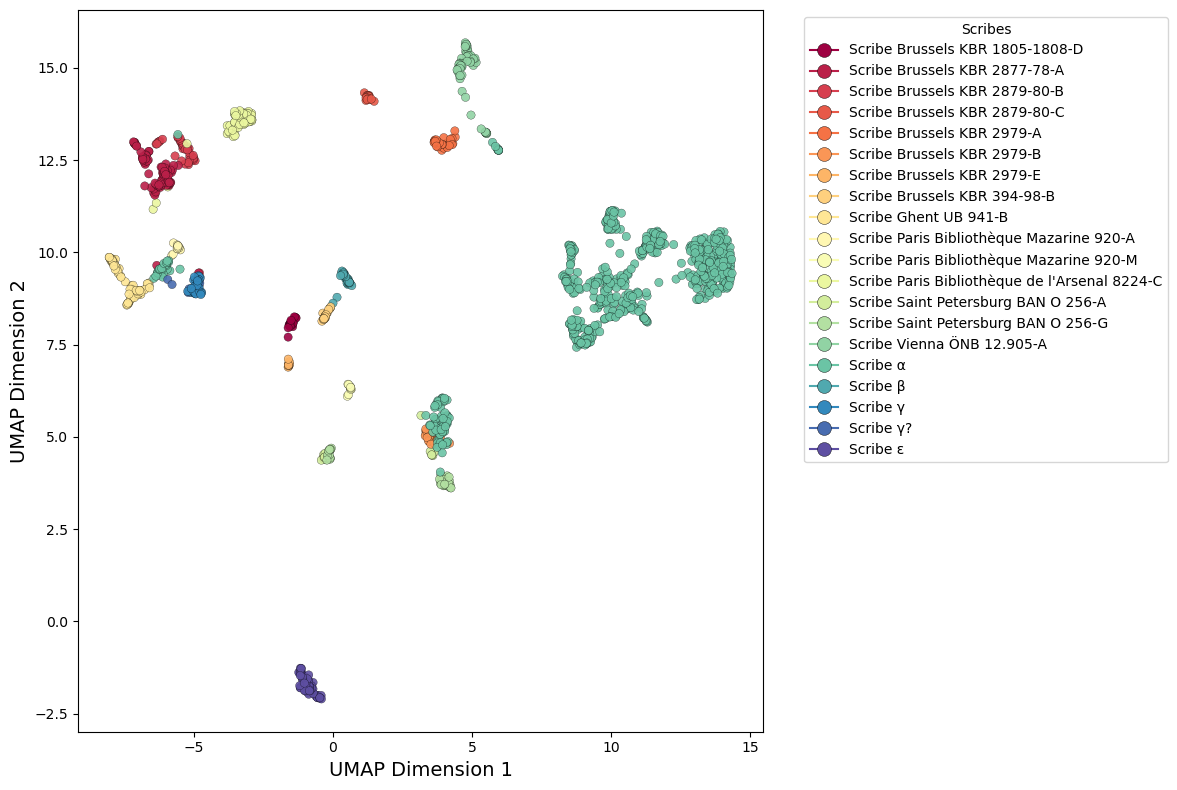

In [13]:
# 1) all texts included

import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
filtered_segments = segments[segments['scribe'].isin(filtered_scribes)]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/scatterplot_all_texts.png', dpi=600, bbox_inches='tight')
plt.show()

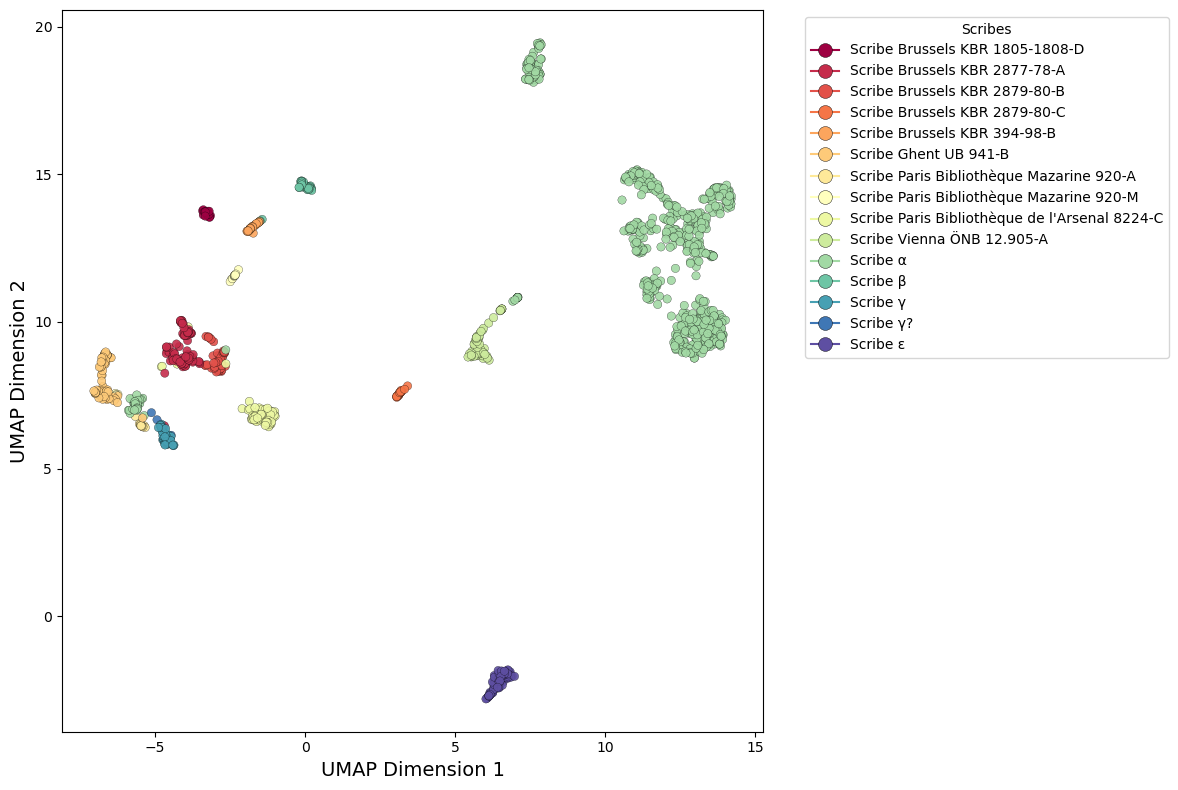

In [14]:
# 2) excluding Brussels KBR 2979 and Saint Petersburg BAN O 256

import umap.umap_ as umap

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = segments['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
# Exclude specific manuscripts based on the signatures
excluded_signatures = ['Brussels KBR 2979', 'Saint Petersburg BAN O 256']
filtered_segments = segments[
    (segments['scribe'].isin(filtered_scribes)) &
    (~segments['signature'].isin(excluded_signatures))
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['scribe'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/scatterplot_gospels_excluded.svg', dpi=600, bbox_inches='tight')
plt.show()


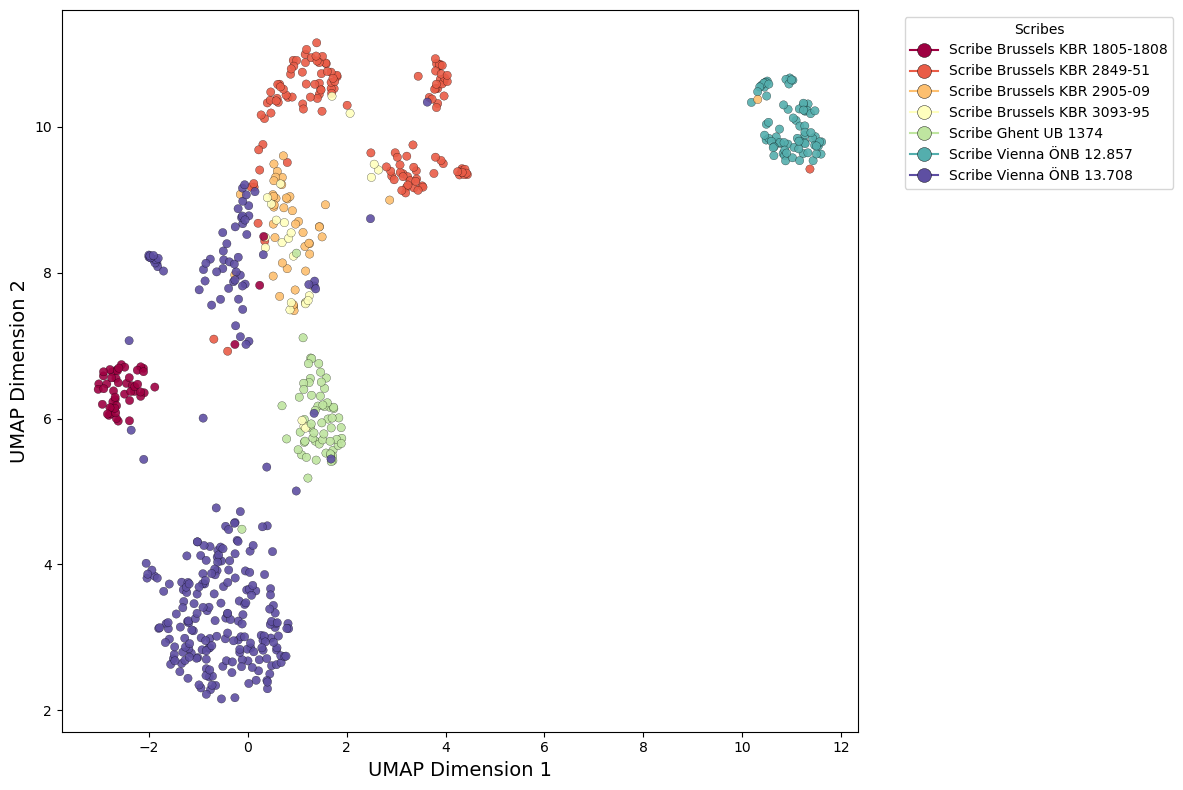

In [15]:
# 3) Only alpha

import umap.umap_ as umap

# We select all segments attributed to scribe α
alpha = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65') & (segments['signature']!= 'Brussels KBR 2979')].copy()

# Filter out scribes with less than 10 segments and exclude 'scribe3'
scribe_counts = alpha['scribe'].value_counts()
filtered_scribes = scribe_counts[scribe_counts >= 10].index
# Exclude specific manuscripts based on the signatures
excluded_signatures = ['Vienna ÖNB 65']
filtered_segments = segments[
    (segments['scribe'].isin(filtered_scribes)) &
    (~segments['signature'].isin(excluded_signatures))
]

# Perform dimensionality reduction with PCA
pca_model = PCA(n_components=25)
X_pca = pca_model.fit_transform(BOW_df.loc[filtered_segments.index])

# Further reduction with UMAP
umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X_pca)

# Label encoding for scribes to color the scatter plot
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(filtered_segments['signature'])

# Create a scatter plot with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=colors, cmap='Spectral', alpha=0.9, edgecolor='black', linewidth=0.2)

# Creating a custom legend that matches the colors of the dots
scribe_labels = label_encoder.classes_
legend_handles = [plt.Line2D([0], [0], marker='o', color=scatter.cmap(scatter.norm(color)), label=f'Scribe {scribe}', markersize=10, markeredgecolor='black', markeredgewidth=0.3) for color, scribe in enumerate(scribe_labels)]

# Place the legend outside the plot on the right side, with a frame
plt.legend(handles=legend_handles, title="Scribes", bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

# Adding titles and labels with enhanced fonts
plt.xlabel('UMAP Dimension 1', fontsize=14)
plt.ylabel('UMAP Dimension 2', fontsize=14)
plt.grid(False)
plt.tight_layout()
plt.savefig('figures/scatterplot_only_alpha.svg', dpi=600, bbox_inches='tight')
plt.show()


### Outlier detection analysis

In [16]:
# apply TF-IDF Vectorizer to all works written by the Speculum Scribe
BOW = vectorizer.fit_transform(alpha['text']).toarray()

# standardize the BOW data for uniformity
BOW = preprocessing.scale(BOW)
BOW.shape

(672, 100)

In [17]:
# one-class SVM for outlier detection
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)

# counting membership values to identify outliers
alpha['membership'].value_counts()
alpha

text    date scribe  \
608   \nHier beghent de tafele hoemē vēdē sal de ewp...  1387.5      α   
658   m xjo\nHier beghent sente matheꝰ\nBMwoec der g...  1387.5      α   
659   eele vā galylea E comē\nde woende hi ī de sta...  1387.5      α   
660   ch si de ōtfarmhʼteghe  wāt si selē\nde ōtfar...  1387.5      α   
661   n sal\ndine slinke hāt niet wetē wat di\nne re...  1387.5      α   
...                                                 ...     ...    ...   
1486  iewe dinc\nSint dꝫ ic kerstendoem ōtfīc\nHebbi...  1402.0      α   
1487  raet an nam\nAls hē dochte te siʼe orbarē\nDit...  1402.0      α   
1488   ōtfermēchede\nEs ontᵒest e vʼranesse mede\nS...  1402.0      α   
1489  ᵃ\nVan den keyser aureliꝰ ꝯmodꝰ lvi\nDine tebe...  1402.0      α   
1490  ē waʼ sagers waer si ware\nMettē godē seidē si...  1402.0      α   

              signature                      id translator    content  \
608   Vienna ÖNB 12.857  Vienna ÖNB 12.857-II-α        NaN  perikopen   
658   Vienna ÖNB 12.857  Vienna ÖNB 12.857-IV-α        NaN      evang   
659   Vienna ÖNB 12.857  Vienna ÖNB 12.857-IV-α        NaN      evang   
660   Vienna ÖNB 12.857  Vienna ÖNB 12.857-IV-α        NaN      evang   
661   Vienna ÖNB 12.857  Vienna ÖNB 12.857-IV-α        NaN      evang   
...                 ...                     ...        ...        ...   
1486  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN     sph2-2   
1487  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN     sph2-2   
1488  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN     sph2-2   
1489  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN     sph2-2   
1490  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN     sph2-2   

      membership  
608           -1  
658           -1  
659           -1  
660           -1  
661            1  
...          ...  
1486           1  
1487           1  
1488          -1  
1489           1  
1490           1  

[672 rows x 8 columns]

In [18]:
# We will now have a closer look at production units as a 
# whole instead of just the segments.

# For every production unit, we train a model. The model is
# always trained on all of the production units written by 
# alhpa, except for 1. The model is then tested on the 1 
# work we left out during training to test whether it was 
# written by α or not. For every segment we test this
# separately. At the end, you get a percentage of which 
# segments of the production units are anomalies and which are
# not

# analyzing purity of production units
purity = []

# looping through each production unit of α
for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)

    # testing on the excluded unit
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])

purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

unit                   codex        -1        +1
0   Brussels KBR 1805-1808-I-α  Brussels KBR 1805-1808  0.296296  0.703704
1     Brussels KBR 2849-51-I-α    Brussels KBR 2849-51  1.000000  0.000000
2    Brussels KBR 2849-51-II-α    Brussels KBR 2849-51  1.000000  0.000000
3   Brussels KBR 2849-51-III-α    Brussels KBR 2849-51  0.900000  0.100000
4    Brussels KBR 2849-51-IV-α    Brussels KBR 2849-51  1.000000  0.000000
5     Brussels KBR 2849-51-V-α    Brussels KBR 2849-51  0.615385  0.384615
6    Brussels KBR 2849-51-VI-α    Brussels KBR 2849-51  0.384615  0.615385
7   Brussels KBR 2849-51-VII-α    Brussels KBR 2849-51  0.321429  0.678571
8    Brussels KBR 2905-09-II-α    Brussels KBR 2905-09  0.454545  0.545455
9     Brussels KBR 3093-95-I-α    Brussels KBR 3093-95  0.800000  0.200000
10   Brussels KBR 3093-95-II-α    Brussels KBR 3093-95  0.833333  0.166667
11           Ghent UB 1374-I-α           Ghent UB 1374  0.000000  1.000000
12          Ghent UB 1374-II-α           Ghent UB 1374  0.481481  0.518519
13         Ghent UB 1374-III-α           Ghent UB 1374  0.875000  0.125000
14          Ghent UB 1374-IV-α           Ghent UB 1374  0.800000  0.200000
15           Ghent UB 1374-V-α           Ghent UB 1374  1.000000  0.000000
16      Vienna ÖNB 12.857-II-α       Vienna ÖNB 12.857  1.000000  0.000000
17      Vienna ÖNB 12.857-IV-α       Vienna ÖNB 12.857  0.855263  0.144737
18       Vienna ÖNB 13.708-I-α       Vienna ÖNB 13.708  0.800000  0.200000
19      Vienna ÖNB 13.708-II-α       Vienna ÖNB 13.708  0.714286  0.285714
20     Vienna ÖNB 13.708-III-α       Vienna ÖNB 13.708  0.526316  0.473684
21      Vienna ÖNB 13.708-IV-α       Vienna ÖNB 13.708  0.476190  0.523810
22      Vienna ÖNB 13.708-IX-α       Vienna ÖNB 13.708  0.866667  0.133333
23       Vienna ÖNB 13.708-V-α       Vienna ÖNB 13.708  0.421053  0.578947
24      Vienna ÖNB 13.708-VI-α       Vienna ÖNB 13.708  0.612903  0.387097
25     Vienna ÖNB 13.708-VII-α       Vienna ÖNB 13.708  0.407407  0.592593
26    Vienna ÖNB 13.708-VIII-α       Vienna ÖNB 13.708  0.371429  0.628571
27       Vienna ÖNB 13.708-X-α       Vienna ÖNB 13.708  0.842105  0.157895
28      Vienna ÖNB 13.708-XI-α       Vienna ÖNB 13.708  0.297297  0.702703

In [19]:
codex_svm_results = purity.groupby('codex').agg({'-1': 'mean', '+1': 'mean'}).sort_values('-1', ascending=False)
codex_svm_results

-1        +1
codex                                     
Vienna ÖNB 12.857       0.927632  0.072368
Brussels KBR 3093-95    0.816667  0.183333
Brussels KBR 2849-51    0.745918  0.254082
Ghent UB 1374           0.631296  0.368704
Vienna ÖNB 13.708       0.575968  0.424032
Brussels KBR 2905-09    0.454545  0.545455
Brussels KBR 1805-1808  0.296296  0.703704

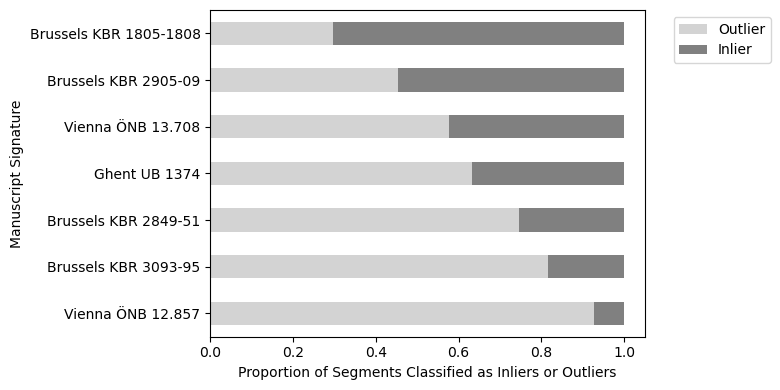

In [20]:
# Gray colours
colors = ['#d3d3d3', '#808080']

# Plotting a stacked bar chart with adjusted font size and layout
ax = codex_svm_results.plot(kind='barh', stacked=True, color=colors, figsize=(8, 4), fontsize=10)

# Setting plot title and labels
plt.xlabel('Proportion of Segments Classified as Inliers or Outliers', fontsize=10)
plt.ylabel('Manuscript Signature', fontsize=10)
plt.xticks(fontsize=10)

# Positioning the legend outside the plot on the right
plt.legend(labels=['Outlier', 'Inlier'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Show plot
plt.tight_layout()
plt.savefig('figures/outliers.png', format='png', dpi=1200)
plt.show()


In [21]:
# create list called 'classes' that labels each segment of alpha as either 'Vienna ÖNB 65' or 'rest', based on the signature column
classes = ['Vienna ÖNB 12.857' if sig == 'Vienna ÖNB 12.857' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names_out()

# rfc is used to differentiate between the 'Vienna ÖNB 65' class and 'rest'
# the model is trained on the BOW representation of the text
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

# after training, the importance of each feature in distinguishing between the two classes is calculated
# the stdev of the importances across all trees in the forest is also calculated
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 15
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

forest_importances

wā    0.009373
ōm    0.010153
hʼ    0.012381
gʼ    0.017282
eʼ    0.019033
     0.019868
E    0.022947
ʼc    0.039109
ēd    0.041709
aʼ    0.066971
dꝫ    0.080630
ʼ     0.084383
hꝫ    0.093886
hē    0.114000
gē    0.189364
dtype: float64

/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/carolinevandyck/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


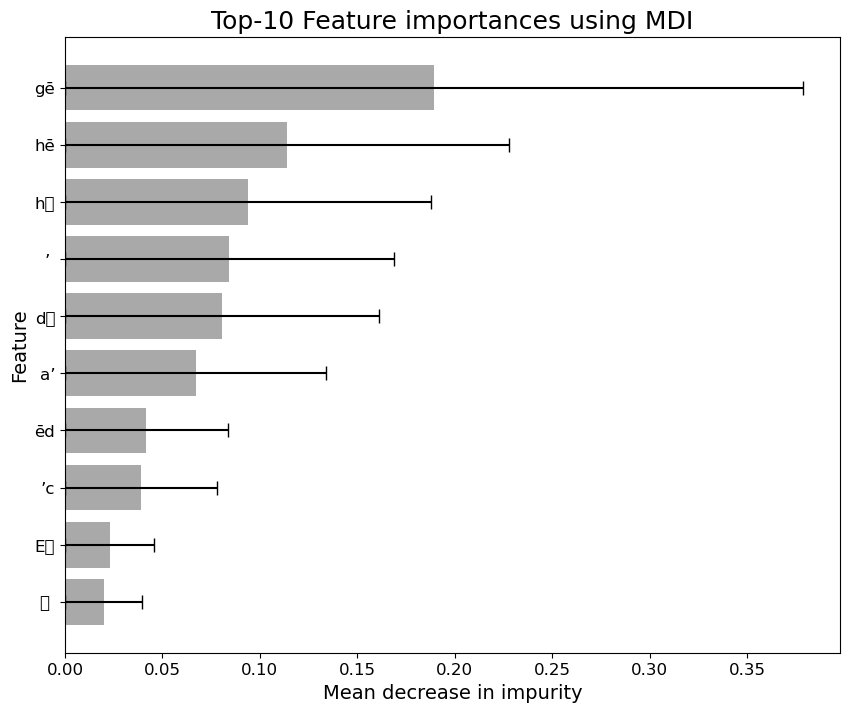

In [22]:
cutoff = 10
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = std.loc[forest_importances.index]

# Create a DataFrame from the feature importances and standard deviations
importance_data = pd.DataFrame({
    'feature': forest_importances.index,
    'importance': forest_importances.values,
    'importance_lower': forest_importances.values - std.values,
    'importance_upper': forest_importances.values + std.values
})

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))

bars = ax.barh(importance_data['feature'], importance_data['importance'], color='darkgrey')

# Adding error bars
for bar, lower, upper in zip(bars, importance_data['importance_lower'], importance_data['importance_upper']):
    ax.errorbar(x=bar.get_width(), y=bar.get_y() + bar.get_height() / 2,
                xerr=[[bar.get_width() - lower], [upper - bar.get_width()]],
                color='black', capsize=5)

# Set labels and title
ax.set_xlabel('Mean decrease in impurity', fontsize=14)
ax.set_ylabel('Feature', fontsize=14)
ax.set_title('Top-10 Feature importances using MDI')

# Customize fonts
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Top-10 Feature importances using MDI', fontsize=18)

plt.show()

In [23]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

         E        ʼc        ēd        aʼ        dꝫ  \
Vienna ÖNB 12.857  1.950506  3.549013  9.063979  1.513229 -0.833732 -1.517316   
Vienna ÖNB 12.857  2.184686  2.575287 -0.088505  2.162675 -0.807330 -1.533209   
Vienna ÖNB 12.857  1.037010  0.949308 -0.402285  3.490418 -1.323713 -1.226726   
Vienna ÖNB 12.857 -0.711336 -0.402968 -0.378260  0.234833 -1.208374 -1.304684   
Vienna ÖNB 12.857 -0.510434 -0.625082 -0.695460 -0.127088 -1.211603 -1.309738   
...                     ...       ...       ...       ...       ...       ...   
rest               0.099288  0.728230 -0.695460 -0.653570  0.268927 -0.677647   
rest              -1.176846 -0.117980 -0.286231 -0.926897  1.067053  0.957043   
rest              -0.880657 -0.596384 -0.185975  0.240194  1.849252 -0.562363   
rest               1.293573  0.706993 -0.695460 -0.606803  1.774417  0.466185   
rest               0.485397  0.657906 -0.695460 -0.646089  0.918852 -0.174616   

                         ʼ         hꝫ        hē        gē  
Vienna ÖNB 12.857  1.262482  1.954185  1.109233 -1.893804  
Vienna ÖNB 12.857 -1.666329  0.504562  0.904254 -1.220307  
Vienna ÖNB 12.857 -0.999118  3.705690  2.036010 -1.893804  
Vienna ÖNB 12.857 -1.757452  5.617169  1.437949 -1.893804  
Vienna ÖNB 12.857 -1.472504  0.153981  1.289918 -1.893804  
...                     ...       ...       ...       ...  
rest              -0.853345 -0.613069  0.435299  0.125691  
rest               0.220805 -0.613069  0.122475 -0.758570  
rest               1.524594  0.012366 -0.057789 -0.480452  
rest               0.569632 -0.613069  0.084896  0.039635  
rest               0.193724 -0.613069 -0.013788 -0.612608  

[672 rows x 10 columns]

In [24]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

index abbreviation     score             origin
0     Vienna ÖNB 12.857              1.950506  Vienna ÖNB 12.857
1     Vienna ÖNB 12.857              2.184686  Vienna ÖNB 12.857
2     Vienna ÖNB 12.857              1.037010  Vienna ÖNB 12.857
3     Vienna ÖNB 12.857             -0.711336  Vienna ÖNB 12.857
4     Vienna ÖNB 12.857             -0.510434  Vienna ÖNB 12.857
...                 ...          ...       ...                ...
6715               rest           gē  0.125691               rest
6716               rest           gē -0.758570               rest
6717               rest           gē -0.480452               rest
6718               rest           gē  0.039635               rest
6719               rest           gē -0.612608               rest

[6720 rows x 4 columns]

In [25]:
bow['abbreviation'].unique()

array(['\ue5dc ', 'E\ue5dc', 'ʼc', 'ēd', 'aʼ', 'dꝫ', 'ʼ ', 'hꝫ', 'hē',
       'gē'], dtype=object)

findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_86632/3583181829.py:25: UserWarning: Glyph 58844 (\ue5dc) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
/var/folders/qv/jgq1ttws58g43xdmt2gthgth0000gn/T/ipykernel_86632/3583181829.py:25: UserWarning: Glyph 42859 (\N{LATIN SMALL LETTER ET}) missing from current font.
  plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Cardo' not found.
findfont: Font family 'Junicode' not found.
findfont: Font family 'Junicode' not found.
findfont: Font famil

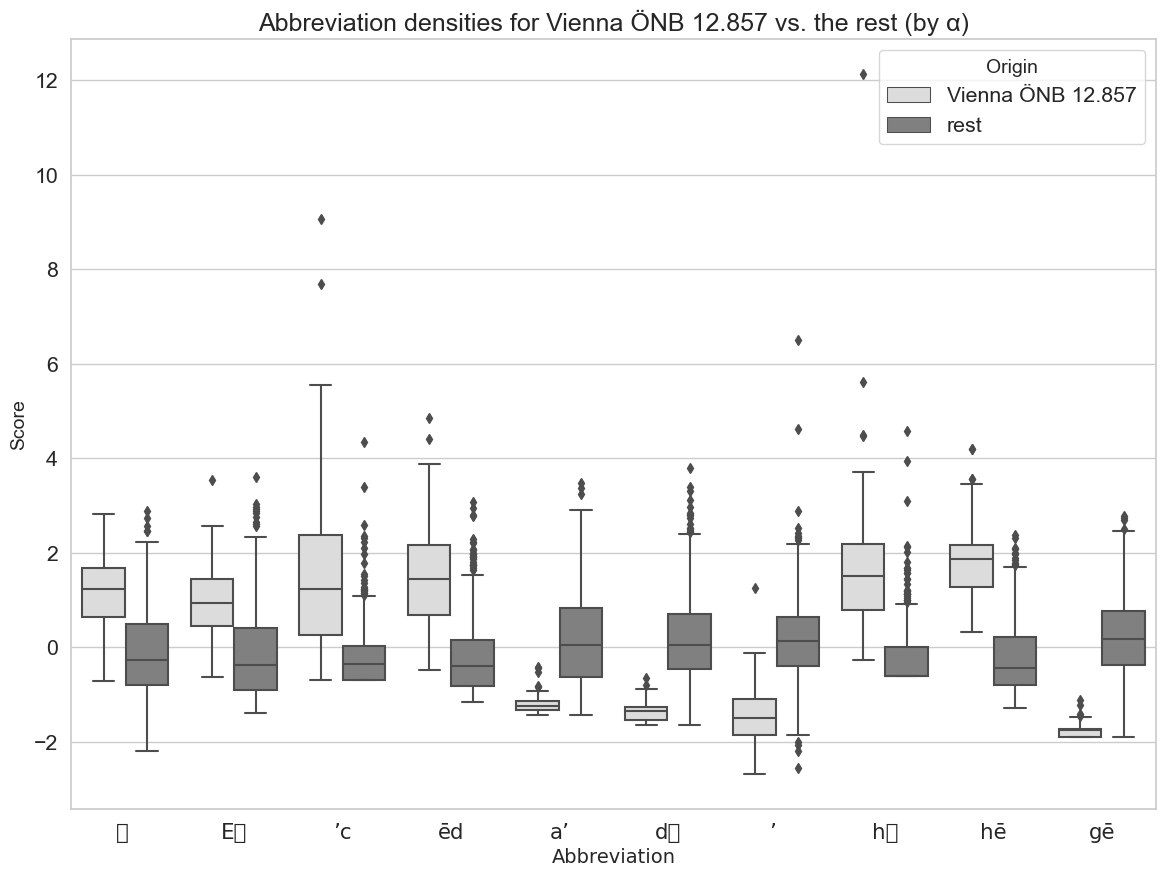

In [26]:
# Set the font style
# set cardo to be the default font for special glyphs
plt.rcParams["font.family"] = "Cardo"
sns.set(style="whitegrid", font_scale=1.4)

# Define a custom color palette with two colors using names
custom_palette = ["gainsboro", "gray"]

# Plotting
plt.figure(figsize=(14, 10))

# Create a boxplot with 'abbreviation' on the x-axis, 'score' on the y-axis, and 'origin' as hue
sns.boxplot(x='abbreviation', y='score', hue='origin', data=bow, palette=custom_palette)

# Set labels and title
plt.xlabel('Abbreviation', fontsize=14, fontname='Junicode')
plt.ylabel('Score', fontsize=14)
plt.title('Abbreviation densities for Vienna ÖNB 12.857 vs. the rest (by α)', fontsize=18)

# Show the legend
plt.legend(title='Origin', title_fontsize='14')

# Set the x-axis labels to use the Junicode font
plt.xticks(fontname='Cardo')
plt.savefig('figures/boxplot.pdf', dpi=600, bbox_inches='tight')
plt.show()

### Investigating the use of d3

We will investigate whether and how often scribe alpha used dꝫ in the context of dat in contrast to dat/det.

In [27]:
# Counting the occurences of dꝫ (dat) compared to all instances of dꝫ

def count_d3(text):
    # dat
    dit_dat = re.findall(r'(?<=[^-]\s)dꝫ(?![\S])|Dꝫ(?![\S])', text) # any non-hyphen character (e.g. to exclude lei-dꝫ at a line break) followed by a whitespace character + dꝫ + a whitespace character or be at the end of the string OR Dꝫ + a whitespace character or be at the end of the string 
    # dat/det
    all_d3 = re.findall(r'dꝫ|Dꝫ', text) # dꝫ OR Dꝫ
    return len(dit_dat) / len(all_d3)

# Group based on 'and 'signature' en 'date' and calculate ratio
ratio_d3 = alpha.groupby(['signature', 'date'])['text'].apply(lambda x: count_d3(''.join(x))).reset_index(name='ratio')

# DataFrame
ratio_d3 = ratio_d3.sort_values('ratio')
ratio_d3

signature    date     ratio
5       Vienna ÖNB 12.857  1387.5  0.078049
3    Brussels KBR 3093-95  1387.5  0.947464
2    Brussels KBR 2905-09  1387.5  0.958194
1    Brussels KBR 2849-51  1387.5  0.969366
4           Ghent UB 1374  1387.5  0.978050
8       Vienna ÖNB 13.708  1394.0  0.981972
0  Brussels KBR 1805-1808  1395.0  0.982958
9       Vienna ÖNB 13.708  1402.0  0.992188
6       Vienna ÖNB 13.708  1393.0  0.993776
7       Vienna ÖNB 13.708  1393.5  0.993915

In [28]:
# Checking whether the regex works in order to extract all instances of dat

# Selecting Vienna ÖNB 12.857
vienna_12857 = alpha[alpha['signature'] == 'Vienna ÖNB 12.857']

# Joining all text rows
combined_text = '\n'.join(vienna_12857['text'])

# Find all instances of dꝫ (dat)
matches = re.finditer(r'(?<=[^-]\s)dꝫ(?![\S])|Dꝫ(?![\S])', combined_text)

# Print the 40 characters before and after every match
for match in matches:
    start_index = max(0, match.start() - 40)
    end_index = min(len(combined_text), match.end() + 40)
    print(combined_text[start_index:match.start()], end='')
    print(combined_text[match.start():match.end()], end='')
    print(combined_text[match.end():end_index])



de iordane dʼ liede vā galylea Dat volc dꝫ
ī dōkʼnessē wādelde sach groet licht  E
ʼ scarē E si atē e si alle ghesathʼs
dꝫ E si dᵒeghē de bleuelinghe dʼ brockē
x
es
ghe ic u  Waert dat ghi gheloeue had
dꝫ e ghi nᵗ ē twifelet ghi ē soudet
nᵗ al
e
daghe salic op vʼstaē  Daerōme ghebie
dꝫ te hoede dat graf tote ī dē derden
dagh
 be
liende hare sondē E ian was ghecle
dꝫ mꝫ hare dʼ kemele e i vellengurdelomtr
hi
hen allen E siatē alle e si ghesa
dꝫ e si droeghē op de bleuelīghe dmē xij 
et
vā dē broedē wāt hare hʼte was vʼble
dꝫ E alse si ouʼuoerē qᵃmēse ī dlāt vā
ge
eiddēne ī de stat golgathā dat es bedie
dꝫ de stat vā caluarien E si gauē hem
drē
 warē  de welke nᵗ gheorlouet ē wa
cxxi
Dꝫ
Lu
rē tetene dā allene dē priesterē E 
ghʼ gods ute wʼpe de duueA
Lu
cxxxix
e dꝫ hueden

cas
le  so cōt haesteleke ī n d
wedʼ sake ī dē weghe tē prīcē doꝫ alsoe dꝫ
ghi ghevrijt wʼt vā hē dat hi di malich
ē  Wi heb
bē vondē messyam dat es bedie dꝫ xc E
hi leidde hē te ihʼm Jhʼc ane sa
aʼ
d

In [29]:
# Adjust signature name for labels in plot
ratio_d3['signature'] = ratio_d3['signature'] + ' (' + ratio_d3['date'].astype(str) + ')'
ratio_d3['signature'] = ratio_d3['signature'].str.replace('1387.5', '1375-1400')
ratio_d3

signature    date     ratio
5     Vienna ÖNB 12.857 (1375-1400)  1387.5  0.078049
3  Brussels KBR 3093-95 (1375-1400)  1387.5  0.947464
2  Brussels KBR 2905-09 (1375-1400)  1387.5  0.958194
1  Brussels KBR 2849-51 (1375-1400)  1387.5  0.969366
4         Ghent UB 1374 (1375-1400)  1387.5  0.978050
8        Vienna ÖNB 13.708 (1394.0)  1394.0  0.981972
0   Brussels KBR 1805-1808 (1395.0)  1395.0  0.982958
9        Vienna ÖNB 13.708 (1402.0)  1402.0  0.992188
6        Vienna ÖNB 13.708 (1393.0)  1393.0  0.993776
7        Vienna ÖNB 13.708 (1393.5)  1393.5  0.993915

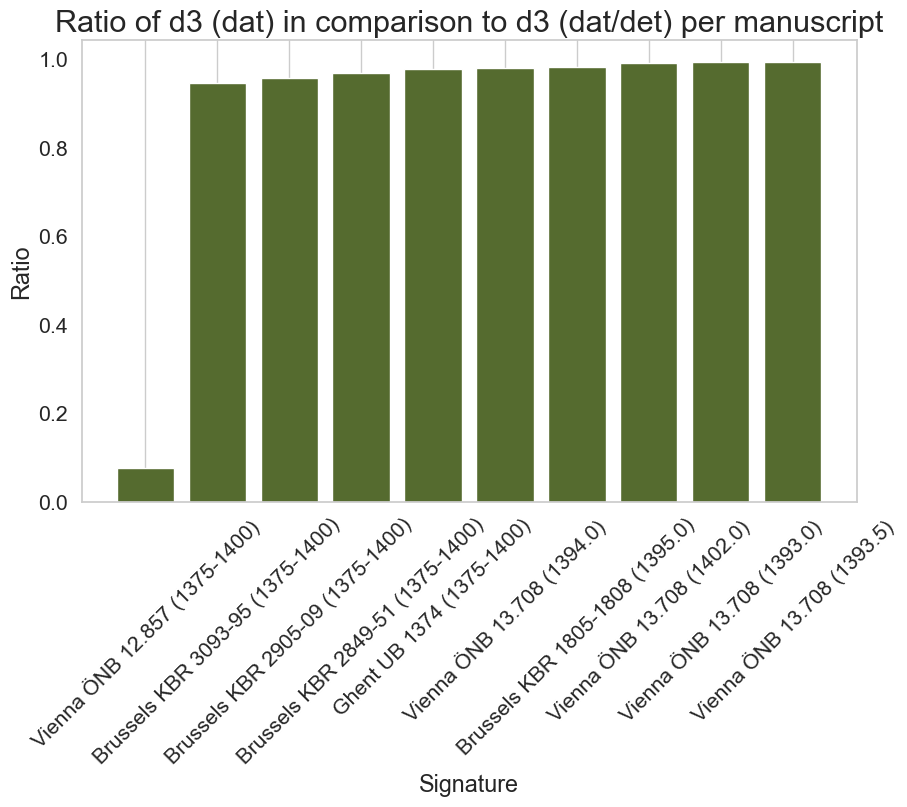

In [30]:
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(ratio_d3['signature'], ratio_d3['ratio'], color='darkolivegreen')
plt.ylabel('Ratio')
plt.xlabel('Signature')
plt.title('Ratio of d3 (dat) in comparison to d3 (dat/det) per manuscript', fontsize=22)
plt.xticks(rotation=45)
plt.grid(axis='y')

# Displaying the plot
plt.show()

### Chronological order

We will now investigate whether an evolution can be seen in his usage of dꝫ in the context of dat in contrast to dat/det. The answer is negative but we left the code in for completeness.

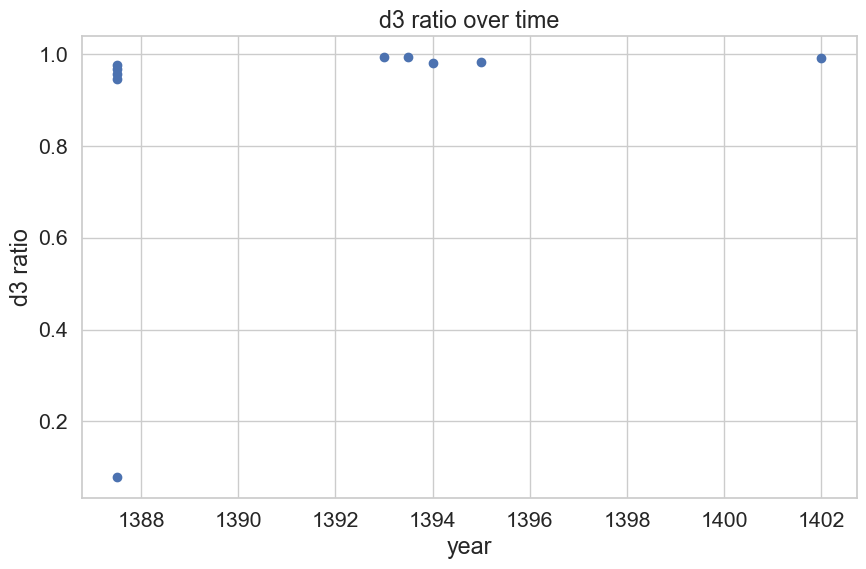

In [31]:
# plot d3 ratio over time

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(ratio_d3['date'], ratio_d3['ratio'], marker='o', linestyle='-')

# Labels and titles
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

plt.grid(True)
plt.show()


### Singling out Heber-Serrure

It is thought that the scribe worked several years (decades?) on the manuscript: is there an evolution? E.g. does he use dꝫ in the context of dat less in the early production units in more in the later ones?

In [32]:
HS = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65') & (segments['signature']== 'Ghent UB 1374')].copy()
HS

text    date scribe  \
1039  Jn dierste partie vā dē spiegele hystoriale Jn...  1387.5      α   
1040  ī \ndu dē ge\ne mꝫ ca\nSie datt \nniene be\nv...  1387.5      α   
1041   negeenē male  Eest\ndattu mate houdē wilt  Al...  1387.5      α   
1042  oꝫ dē goedē mā  So cleenē\ndiēst geenē godweet...  1387.5      α   
1043  ē  Want\nmē machʼ nᵗ ōtfliē  Mʼ daʼ iegē si s...  1387.5      α   
...                                                 ...     ...    ...   
1125  one  Berecht mi nv vā den\nꝑsone  Die mē heet ...  1387.5      α   
1126   boese dade  Werde god laꝫ ōs ver\ndingē  Onse...  1387.5      α   
1127  e tᵉkē  Dꝫ hʼen mettē mō\nde spᵉkē  Dies \nsi\...  1387.5      α   
1128  scout  Vā sinē mesdadē  Mʼtē ochtu dich\n\n\n\...  1387.5      α   
1129   conīgē  Mēschē sōder blame  Daer die conīge n...  1387.5      α   

          signature                   id translator  \
1039  Ghent UB 1374   Ghent UB 1374-II-α        NaN   
1040  Ghent UB 1374   Ghent UB 1374-II-α        NaN   
1041  Ghent UB 1374   Ghent UB 1374-II-α        NaN   
1042  Ghent UB 1374   Ghent UB 1374-II-α        NaN   
1043  Ghent UB 1374   Ghent UB 1374-II-α        NaN   
...             ...                  ...        ...   
1125  Ghent UB 1374  Ghent UB 1374-III-α        NaN   
1126  Ghent UB 1374  Ghent UB 1374-III-α        NaN   
1127  Ghent UB 1374  Ghent UB 1374-III-α        NaN   
1128  Ghent UB 1374  Ghent UB 1374-III-α        NaN   
1129  Ghent UB 1374  Ghent UB 1374-III-α        NaN   

                                                content  
1039  SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...  
1040  SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...  
1041  SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...  
1042  SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...  
1043  SpH1_8 - SpH1_8-SpH2_1 - SpH2_1 - SpH2_1-SpH3_...  
...                                                 ...  
1125  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  
1126  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  
1127  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  
1128  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  
1129  SpH4_5 - SpH4_5-eerstemartijn - eerstemartijn ...  

[64 rows x 7 columns]

In [33]:
d3_HS = HS.groupby(['id', 'date'])['text'].apply(lambda x: count_d3(''.join(x))).reset_index(name='ratio')

# DataFrame
print(d3_HS.sort_values('ratio'))

                    id    date     ratio
1   Ghent UB 1374-II-α  1387.5  0.968468
2  Ghent UB 1374-III-α  1387.5  0.981481
3   Ghent UB 1374-IV-α  1387.5  0.995516
0    Ghent UB 1374-I-α  1387.5  1.000000
4    Ghent UB 1374-V-α  1387.5  1.000000


It is thought that this manuscript was written over the course of several years/decades. However, no evolution can be seen between early or late production units.

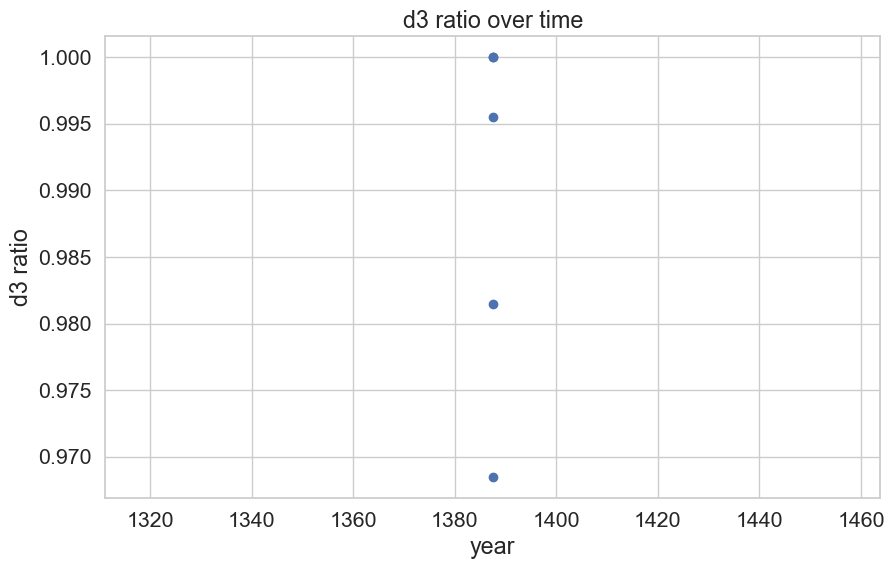

In [34]:
# Graph
plt.figure(figsize=(10, 6)) 
plt.scatter(d3_HS['date'], d3_HS['ratio'], marker='o', linestyle='-')

# Lables and titles
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

plt.grid(True)
plt.show()

### Singling out Vienna 13.708

The scribe worked on the manuscript in two phases: is there an evolution? E.g. does he uses dꝫ in the context of dat less in the early production units in more in the later ones?

In [35]:
vienna = segments[(segments['scribe'] == 'α') & (segments['signature']!= 'Vienna ÖNB 65') & (segments['signature']== 'Vienna ÖNB 13.708')].copy()
vienna

text    date scribe  \
1133  a\nDoemē screef mccc e xcvi\nop de derde none...  1393.0      α   
1134  e wʼden wi vermaēt na dexēpel\nvan dē machabee...  1393.0      α   
1135   maede xx dage e twee\n\nNoᵃ\nDꝫ geen wijf ē ...  1393.0      α   
1136   mē dʼ martelarē vite\nBescⁱuē soude met vlite...  1393.0      α   
1137  at\nDijftiē cardinale ōme dat\nNoᵃ Si vᵒech e...  1393.0      α   
...                                                 ...     ...    ...   
1486  iewe dinc\nSint dꝫ ic kerstendoem ōtfīc\nHebbi...  1402.0      α   
1487  raet an nam\nAls hē dochte te siʼe orbarē\nDit...  1402.0      α   
1488   ōtfermēchede\nEs ontᵒest e vʼranesse mede\nS...  1402.0      α   
1489  ᵃ\nVan den keyser aureliꝰ ꝯmodꝰ lvi\nDine tebe...  1402.0      α   
1490  ē waʼ sagers waer si ware\nMettē godē seidē si...  1402.0      α   

              signature                      id translator  \
1133  Vienna ÖNB 13.708  Vienna ÖNB 13.708-II-α        NaN   
1134  Vienna ÖNB 13.708  Vienna ÖNB 13.708-II-α        NaN   
1135  Vienna ÖNB 13.708  Vienna ÖNB 13.708-II-α        NaN   
1136  Vienna ÖNB 13.708  Vienna ÖNB 13.708-II-α        NaN   
1137  Vienna ÖNB 13.708  Vienna ÖNB 13.708-II-α        NaN   
...                 ...                     ...        ...   
1486  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN   
1487  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN   
1488  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN   
1489  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN   
1490  Vienna ÖNB 13.708  Vienna ÖNB 13.708-IV-α        NaN   

                                                content  
1133  kroniekbrabant - sph4 - lekenspiegel - corpusi...  
1134  kroniekbrabant - sph4 - lekenspiegel - corpusi...  
1135  kroniekbrabant - sph4 - lekenspiegel - corpusi...  
1136  kroniekbrabant - sph4 - lekenspiegel - corpusi...  
1137  kroniekbrabant - sph4 - lekenspiegel - corpusi...  
...                                                 ...  
1486                                             sph2-2  
1487                                             sph2-2  
1488                                             sph2-2  
1489                                             sph2-2  
1490                                             sph2-2  

[271 rows x 7 columns]

In [36]:
d3_vienna = vienna.groupby(['id', 'date'])['text'].apply(lambda x: count_d3(''.join(x))).reset_index(name='ratio')

# DataFrame
print(d3_vienna.sort_values('ratio'))

                          id    date     ratio
10    Vienna ÖNB 13.708-XI-α  1394.0  0.981972
6     Vienna ÖNB 13.708-VI-α  1402.0  0.986301
3     Vienna ÖNB 13.708-IV-α  1402.0  0.986486
4     Vienna ÖNB 13.708-IX-α  1402.0  0.989189
0      Vienna ÖNB 13.708-I-α  1402.0  0.991803
7    Vienna ÖNB 13.708-VII-α  1402.0  0.993220
1     Vienna ÖNB 13.708-II-α  1393.0  0.993776
9      Vienna ÖNB 13.708-X-α  1393.5  0.993915
5      Vienna ÖNB 13.708-V-α  1402.0  0.994350
2    Vienna ÖNB 13.708-III-α  1402.0  0.995192
8   Vienna ÖNB 13.708-VIII-α  1402.0  0.997253


Production units II, X and XI (and perhaps I) were written in 1393-1394, the rest was added in 1402, but no difference can be observed.

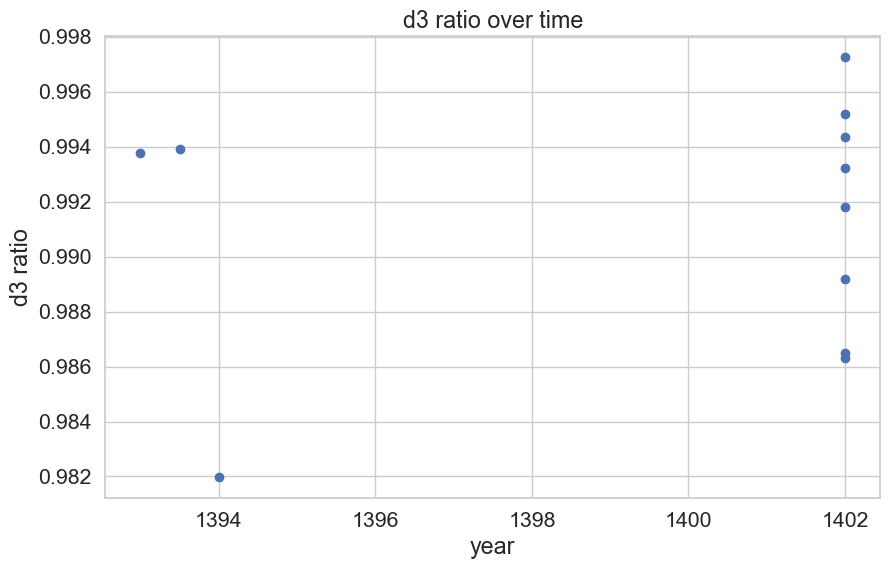

In [37]:
import matplotlib.pyplot as plt

# Graph
plt.figure(figsize=(10, 6))
plt.scatter(d3_vienna['date'], d3_vienna['ratio'], marker='o', linestyle='-')

# Labels and titles
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

# Graph
plt.grid(True)
plt.show()

### Per production unit

In [38]:
ratio_d3_per_pu = alpha.groupby(['id', 'date'])['text'].apply(lambda x: count_d3(''.join(x))).reset_index(name='ratio')

# Toon de resulterende DataFrame
ratio_d3_per_pu = ratio_d3_per_pu.sort_values('ratio')
ratio_d3_per_pu

id    date     ratio
16      Vienna ÖNB 12.857-II-α  1387.5  0.000000
17      Vienna ÖNB 12.857-IV-α  1387.5  0.078431
6    Brussels KBR 2849-51-VI-α  1387.5  0.925125
10   Brussels KBR 3093-95-II-α  1387.5  0.938303
8    Brussels KBR 2905-09-II-α  1387.5  0.958194
3   Brussels KBR 2849-51-III-α  1387.5  0.966216
12          Ghent UB 1374-II-α  1387.5  0.968468
9     Brussels KBR 3093-95-I-α  1387.5  0.969325
13         Ghent UB 1374-III-α  1387.5  0.981481
28      Vienna ÖNB 13.708-XI-α  1394.0  0.981972
0   Brussels KBR 1805-1808-I-α  1395.0  0.982958
5     Brussels KBR 2849-51-V-α  1387.5  0.984831
4    Brussels KBR 2849-51-IV-α  1387.5  0.985714
24      Vienna ÖNB 13.708-VI-α  1402.0  0.986301
21      Vienna ÖNB 13.708-IV-α  1402.0  0.986486
7   Brussels KBR 2849-51-VII-α  1387.5  0.988304
22      Vienna ÖNB 13.708-IX-α  1402.0  0.989189
18       Vienna ÖNB 13.708-I-α  1402.0  0.991803
25     Vienna ÖNB 13.708-VII-α  1402.0  0.993220
19      Vienna ÖNB 13.708-II-α  1393.0  0.993776
27       Vienna ÖNB 13.708-X-α  1393.5  0.993915
23       Vienna ÖNB 13.708-V-α  1402.0  0.994350
20     Vienna ÖNB 13.708-III-α  1402.0  0.995192
14          Ghent UB 1374-IV-α  1387.5  0.995516
26    Vienna ÖNB 13.708-VIII-α  1402.0  0.997253
2    Brussels KBR 2849-51-II-α  1387.5  1.000000
15           Ghent UB 1374-V-α  1387.5  1.000000
1     Brussels KBR 2849-51-I-α  1387.5  1.000000
11           Ghent UB 1374-I-α  1387.5  1.000000

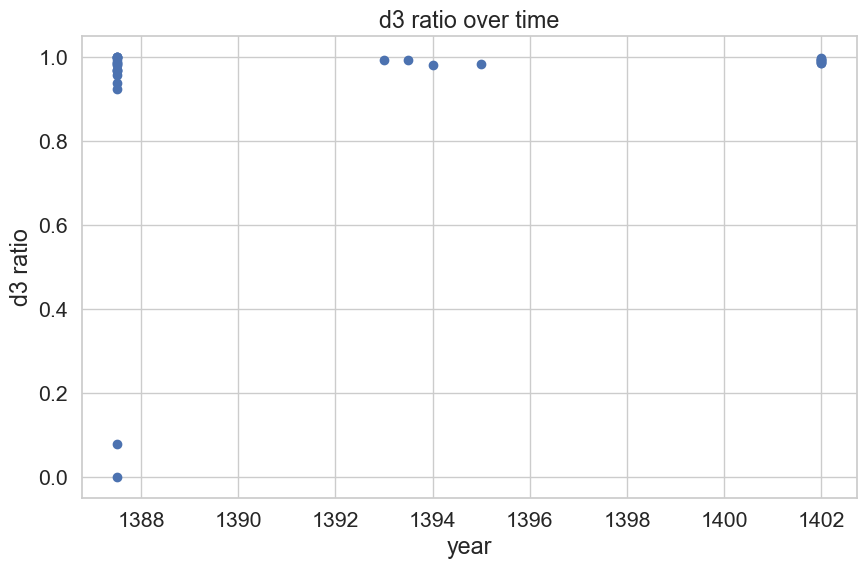

In [39]:
import matplotlib.pyplot as plt

# Graph
plt.figure(figsize=(10, 6))
plt.scatter(ratio_d3_per_pu['date'], ratio_d3_per_pu['ratio'], marker='o', linestyle='-')

# Labels and titles
plt.xlabel('year')
plt.ylabel('d3 ratio')
plt.title('d3 ratio over time')

plt.grid(True)
plt.show()